In [3]:
#Import libraries and set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import warnings 
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [7]:
# load dataset
import pandas as pd
import os

file_path = os.path.join("..", "data", "AIML Dataset.csv")

df = pd.read_csv(file_path, header=None)

df.columns = [
    "step",
    "type",
    "amount",
    "nameOrig",
    "oldbalanceOrg",
    "newbalanceOrig",
    "nameDest",
    "oldbalanceDest",
    "newbalanceDest",
    "isFraud",
    "isFlaggedFraud"
]

df["step"] = df["step"].astype(str).str.extract(r'(\d+)').astype(int)
# Inspect data
print(df.head())
print(df.dtypes)


   step      type    amount  ... newbalanceDest  isFraud  isFlaggedFraud
0     1   PAYMENT   9839.64  ...            0.0        0               0
1     1   PAYMENT   1864.28  ...            0.0        0               0
2     1  TRANSFER    181.00  ...            0.0        1               0
3     1  CASH_OUT    181.00  ...            0.0        1               0
4     1   PAYMENT  11668.14  ...            0.0        0               0

[5 rows x 11 columns]
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [18]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [19]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [20]:
df.isnull().sum().sum()

np.int64(0)

In [21]:
df.shape[0]

6362620

In [22]:
round((df["isFraud"].value_counts()[1] / df.shape[0])* 100,2)

np.float64(0.13)

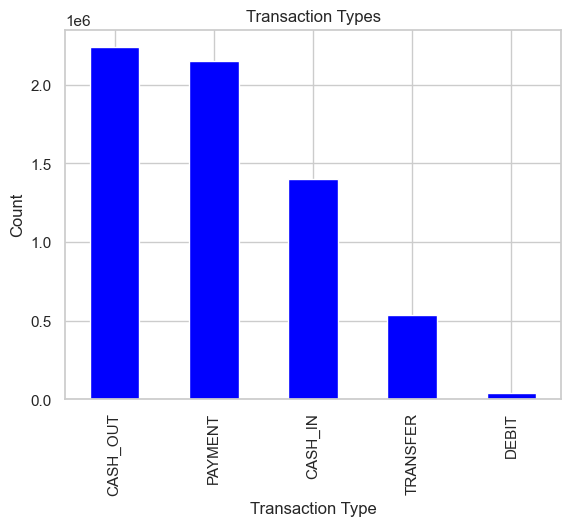

In [23]:
# EDA - Transaction types and fraud rate
df["type"].value_counts().plot(kind="bar", title="Transaction Types", color='blue')
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

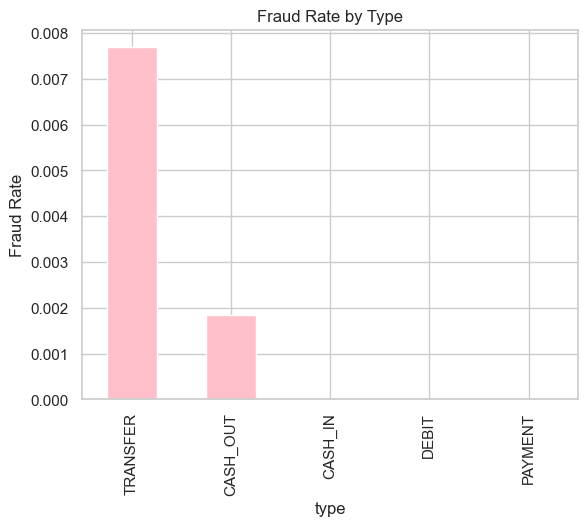

In [24]:
# EDA - Transaction types and fraud rate
fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
fraud_by_type.plot(kind="bar", title="Fraud Rate by Type", color="pink")
plt.ylabel("Fraud Rate")
plt.show()

In [25]:
df["amount"].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int64

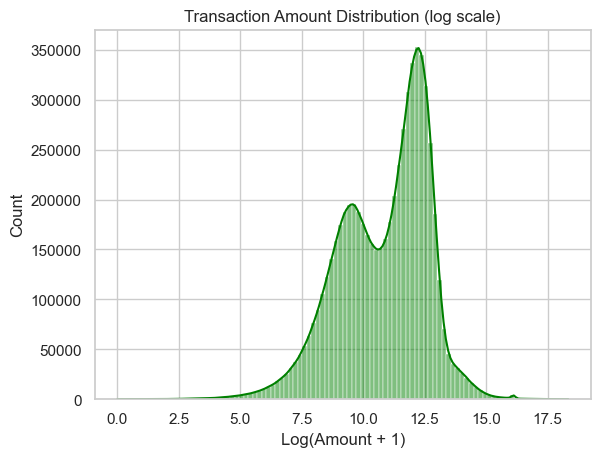

In [26]:
# EDA - Transaction amount distribution
sns.histplot(np.log1p(df["amount"]), bins=100, kde=True, color="green")
plt.title("Transaction Amount Distribution (log scale)")
plt.xlabel("Log(Amount + 1)")
plt.show()

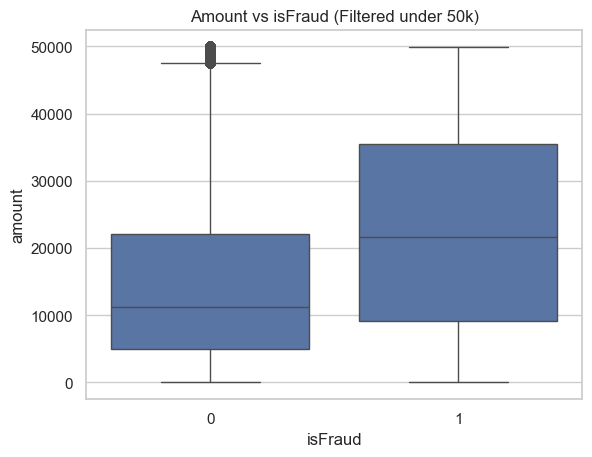

In [27]:
# EDA - Transaction amount distribution
sns.boxplot(data= df[df["amount"] < 50000], x = "isFraud", y="amount")
plt.title("Amount vs isFraud (Filtered under 50k)")
plt.show()

In [28]:
# Feature engineering - balance differences
df["balanceDiffOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balanceDiffDest"] = df["newbalanceDest"] - df["oldbalanceDest"]

In [29]:
# Prepare data for modeling 
df_model = df.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis=1)

categorical = ["type"]
numeric = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", 
        "balanceDiffOrig", "balanceDiffDest"] 

y = df_model["isFraud"]
X = df_model.drop("isFraud", axis=1)

In [30]:
(df["balanceDiffOrig"] < 0).sum()

np.int64(1399253)

In [31]:
(df["balanceDiffDest"] < 0).sum()

np.int64(1238864)

In [32]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


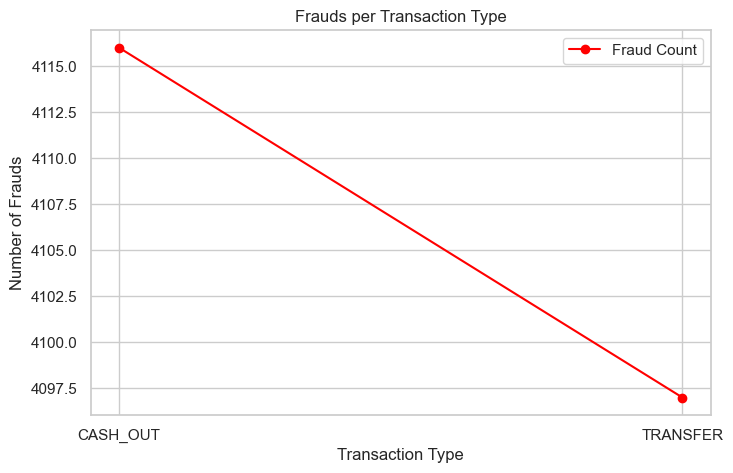

In [33]:
# Fraud distribution per type and over time
frauds_per_type = df[df["isFraud"] == 1]["type"].value_counts()

plt.figure(figsize=(8,5))
plt.plot(frauds_per_type.index, frauds_per_type.values, marker='o', linestyle='-', color='red', label="Fraud Count")
plt.xlabel("Transaction Type")
plt.ylabel("Number of Frauds")
plt.title("Frauds per Transaction Type")
plt.grid(True)
plt.legend()
plt.show()

In [34]:
df["step"] = df["step"].astype(str).str.extract(r'(\d+)')
df["step"] = pd.to_numeric(df["step"], errors="coerce")
df = df.dropna(subset=["step"])
df["step"] = df["step"].astype(int)

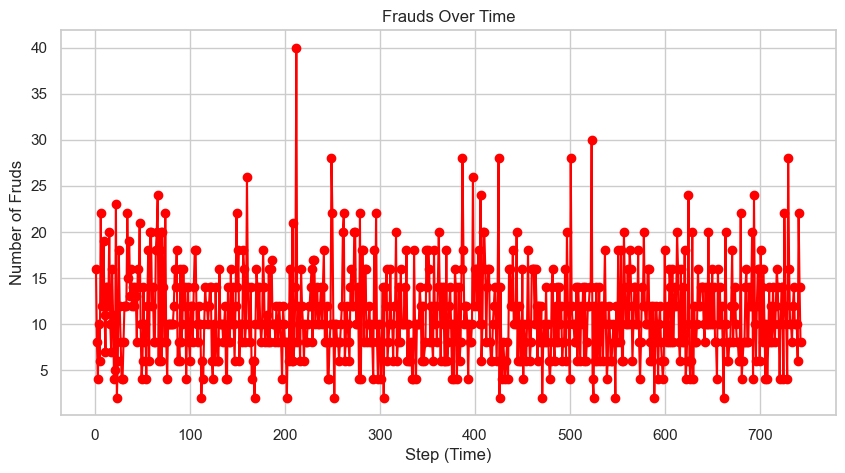

In [35]:
# Fraud distribution per type and over time
frauds_per_step = df[df["isFraud"] == 1]["step"].value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.plot(frauds_per_step.index, frauds_per_step.values, marker='o', linestyle='-', color='red')
plt.xlabel("Step (Time)")
plt.ylabel("Number of Fruds")
plt.title("Frauds Over Time")
plt.grid(True)
plt.show()

In [36]:
df.drop(columns="step", inplace=True)

In [37]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [38]:
# Top users analysis
top_senders = df["nameOrig"].value_counts().head(10)

In [39]:
top_senders

nameOrig
C1677795071    3
C1999539787    3
C724452879     3
C1976208114    3
C400299098     3
C1784010646    3
C1530544995    3
C1065307291    3
C545315117     3
C1902386530    3
Name: count, dtype: int64

In [40]:
top_receivers = df["nameDest"].value_counts().head(10)

In [41]:
top_receivers

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C1789550256     99
C451111351      99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

In [42]:
fraud_users = df[df["isFraud"]==1]["nameOrig"].value_counts().head(10)

In [43]:
fraud_users

nameOrig
C1305486145    1
C840083671     1
C1420196421    1
C2101527076    1
C137533655     1
C1118430673    1
C749981943     1
C1334405552    1
C467632528     1
C1364127192    1
Name: count, dtype: int64

In [44]:
# Fraud distribution for specific transaction types
fraud_types = df[df["type"].isin(["TRANSFER", "CASH_OUT"])]

In [45]:
fraud_types.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89


In [46]:
fraud_types["type"].value_counts()

type
CASH_OUT    2237500
TRANSFER     532909
Name: count, dtype: int64

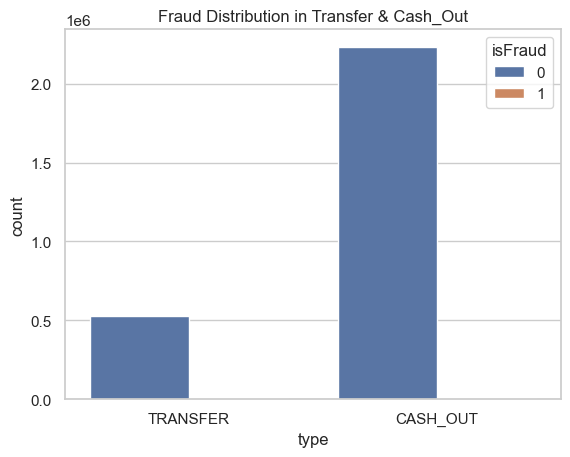

In [47]:
# Fraud distribution for specific transaction types
sns.countplot(data=fraud_types, x="type", hue="isFraud")
plt.title("Fraud Distribution in Transfer & Cash_Out")
plt.show()

In [48]:
# Correlation analysis
corr = df[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFraud"]].corr()

In [49]:
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


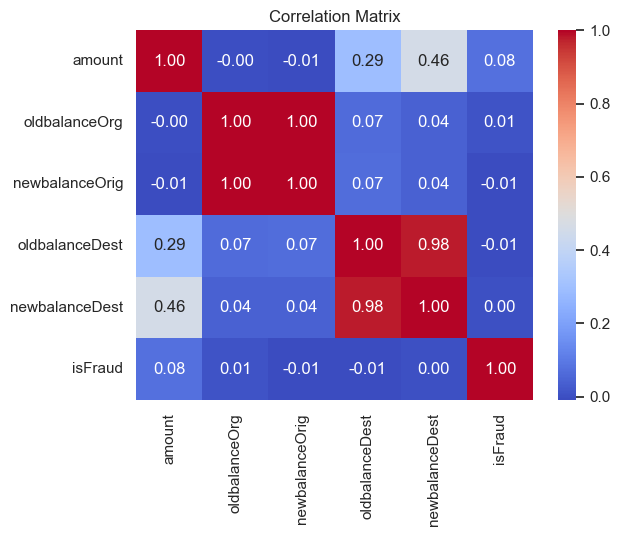

In [50]:
#  Correlation analysis
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [51]:
zero_after_transfer = df[
    (df["oldbalanceOrg"] > 0)&
    (df["newbalanceOrig"] == 0)&
    (df["type"].isin(["TRANSFER", "CASH_OUT"]))
]

In [52]:
len(zero_after_transfer)

1188074

In [53]:
zero_after_transfer.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89


In [54]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [63]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [64]:
# Prepare data for modeling 
df_model = df.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis=1)

In [65]:
df_model.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,9839.64,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1864.28,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,181.00,0.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,181.00,-21182.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,11668.14,0.0


In [66]:
categorical = ["type"]
numeric = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest",
        "balanceDiffOrig", "balanceDiffDest"]

In [67]:
y = df_model["isFraud"]
x = df_model.drop("isFraud", axis=1)

In [68]:
# Prepare data for modeling
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, stratify=y)

In [69]:
# Preprocessing

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric),
        ("cat", OneHotEncoder(drop="first"), categorical)
    ],
    remainder="drop"
)

In [70]:
# Improve pipleline model
pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
])

In [71]:
# Train and evaluate the model
pipeline.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [72]:
y_pred = pipeline.predict(X_test)

In [73]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       1.00      0.95      0.97   1906322\n           1       0.02      0.94      0.04      2464\n\n    accuracy                           0.95   1908786\n   macro avg       0.51      0.94      0.51   1908786\nweighted avg       1.00      0.95      0.97   1908786\n'

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



In [75]:
confusion_matrix(y_test, y_pred)

array([[1805247,  101075],
       [    144,    2320]])

In [76]:
pipeline.score(X_test, y_test) * 100

94.69720544890836

In [78]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# Predict probabilities
y_proba = pipeline.predict_proba(X_test)[:, 1]

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba) * 100
print("ROC-AUC Score:", roc_auc)

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision) * 100
print("PR-AUC Score:", pr_auc)


ROC-AUC Score: 98.92585401577405
PR-AUC Score: 55.72795119042869


In [79]:
# Custom thresthold tuning 
thresthold = 0.3
y_pred_custom = (y_proba >= thresthold).astype(int)

print("Classification Report (Thresthold = 0.3)")
print (classification_report(y_test, y_pred_custom))
confusion_matrix(y_test, y_pred_custom)

Classification Report (Thresthold = 0.3)
              precision    recall  f1-score   support

           0       1.00      0.89      0.94   1906322
           1       0.01      0.99      0.02      2464

    accuracy                           0.89   1908786
   macro avg       0.51      0.94      0.48   1908786
weighted avg       1.00      0.89      0.94   1908786



array([[1693708,  212614],
       [     17,    2447]])

In [86]:
# Risk score (0-100)
risk_score = y_proba * 100

risk_df = pd.DataFrame({
    "Actual": y_test.values,
    "Risk_Score": risk_score 
})

risk_df["Risk_Score"] = (risk_df["Risk_Score"]).clip(lower=0.001).round(2)
risk_df.head()

,Actual,Risk_Score
0,0,53.74
1,0,16.77
2,0,0.00
3,0,0.00
4,0,0.00


In [87]:
def risk_label(score):
    if score < 30:
        return "Low Risk"
    elif score < 70:
        return "Warning"
    else:
        return "High Risk"
    
risk_df["Risk_Level"] = risk_df["Risk_Score"].apply(risk_label)
risk_df.head()

,Actual,Risk_Score,Risk_Level
0,0,53.74,Warning
1,0,16.77,Low Risk
2,0,0.00,Low Risk
3,0,0.00,Low Risk
4,0,0.00,Low Risk


In [88]:
# Feature importance (Logistic Regression)
feature_names = pipeline.named_steps["prep"].get_feature_names_out()
coefficients = pipeline.named_steps["clf"].coef_[0]

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

importance_df["Abs_Coefficient"] = importance_df["Coefficient"].abs()
importance_df = importance_df.sort_values("Abs_Coefficient", ascending=False)

importance_df.head(10)


,Feature,Coefficient,Abs_Coefficient
10,cat__type_TRANSFER,14.696018,14.696018
9,cat__type_PAYMENT,-13.741921,13.741921
7,cat__type_CASH_OUT,13.170739,13.170739
6,num__balanceDiffDest,-9.252868,9.252868
5,num__balanceDiffOrig,3.634750,3.634750
8,cat__type_DEBIT,-2.481264,2.481264
4,num__newbalanceDest,-1.267336,1.267336
3,num__oldbalanceDest,0.829034,0.829034
1,num__oldbalanceOrg,0.565461,0.565461
2,num__newbalanceOrig,0.376283,0.376283


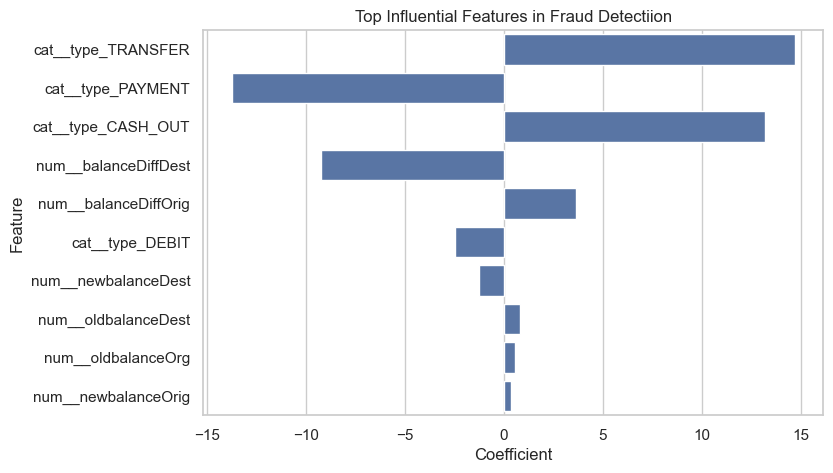

In [89]:
plt.figure(figsize=(8,5))
sns.barplot(
    data = importance_df.head(10),
    x = "Coefficient",
    y = "Feature"
)
plt.title("Top Influential Features in Fraud Detectiion")
plt.show()

In [90]:
# Save the trained pipeline
import os
import joblib

os.makedirs("models", exist_ok=True)

joblib.dump(pipeline, "models/fraud_detection_pipeline.pkl")


['models/fraud_detection_pipeline.pkl']